In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import seaborn as sns
import itertools
from characteriation.viz import *

import matplotlib as mpl

# Set global font and style
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

## Load data

In [2]:
paths = [
    "metadata/metadata_brats25met.csv",
    "metadata/metadata_brats25ssa.csv",
    "metadata/metadata_brats25men.csv",
    "metadata/metadata_episurg.csv",
    "metadata/metadata_isles22.csv",
    "metadata/metadata_msbaghdad.csv",
    "metadata/metadata_mslesseg.csv",
    "metadata/metadata_msseg2.csv",
    "metadata/metadata_oasis1.csv",
    "metadata/metadata_oasis2.csv",
    "metadata/metadata_ixi.csv",
    "metadata/metadata_umfpd.csv",
    "metadata/metadata_nfbs.csv",
    "metadata/metadata_brainmetshare.csv",
]

dfs = []
for path in paths:
    df_ = pd.read_csv(path)
    print(path, df_.shape)
    dfs.append(df_)

df = pd.concat(dfs)

metadata/metadata_brats25met.csv (5900, 16)
metadata/metadata_brats25ssa.csv (380, 16)
metadata/metadata_brats25men.csv (4564, 16)
metadata/metadata_episurg.csv (698, 16)
metadata/metadata_isles22.csv (750, 16)
metadata/metadata_msbaghdad.csv (180, 16)
metadata/metadata_mslesseg.csv (345, 16)
metadata/metadata_msseg2.csv (80, 16)
metadata/metadata_oasis1.csv (436, 16)
metadata/metadata_oasis2.csv (373, 16)
metadata/metadata_ixi.csv (2306, 16)
metadata/metadata_umfpd.csv (83, 16)
metadata/metadata_nfbs.csv (125, 16)
metadata/metadata_brainmetshare.csv (624, 16)


In [3]:
n_patients = len(df['patient'].unique())
print(f"There are {n_patients} patients, {df.shape[0]} images.")

There are 5034 patients, 16844 images.


In [4]:
df.columns

Index(['shape', 'voxel_spacing', 'axcodes', 'min_value', 'max_value',
       'median_value', 'affine', 'orientation', 'is_hwd', 'image_id',
       'patient', 'modality', 'timepoint', 'image_path',
       'preprocessed_image_path', 'dataset'],
      dtype='object')

## Co-occurance of modalities

In [5]:
modality_mapping = {
    't1c': 'T1C',
    't1n': 'T1',
    't1': 'T1',
    't1w': 'T1',
    't1wi': 'T1',
    't1pre': 'T1',
    'bravo': 'T1C', # BrainMetShare specific
    't1post': 'T1C',
    't1gd': 'T1C',
    't1ce': 'T1C',
    
    't2': 'T2',
    't2w': 'T2',
    't2wi': 'T2',
    't2f': 'FLAIR',
    't2-flair': 'FLAIR',
    'flair': 'FLAIR',
    
    'adc': 'ADC',
    'dwi': 'DWI',
    'dti': 'DTI',
    
    'swi': 'SWI',
    'gre': 'GRE',
    'qsm': 'QSM',
    'pd': 'PD',
    'pwi': 'PD',
    
    'asl': 'ASL',
    'tof': 'TOF',
    'mra': 'MRA',
    'mrv': 'MRV',
    
}

def map_modality(modality):
    if modality in modality_mapping.keys():
        return modality_mapping[modality]
    else:
        return modality

def get_coocurrence(df, column, groupby="patient"):
    # Group modalities per patient
    grouped = df.groupby('patient')['modality'].apply(set).reset_index()

    # Sort and join as string of MRI sequences for consistency
    grouped['modality_combo'] = grouped['modality'].apply(lambda x: '-'.join(sorted(x)))

    # Count how many patients have each modality combination
    combo_counts = grouped['modality_combo'].value_counts().reset_index()
    combo_counts.columns = ['modality_combo', 'count']

    # list of all unique modalities from your data
    all_modalities = sorted(set(itertools.chain.from_iterable(grouped['modality'])))

    # initialize matrix
    co_occurrence = pd.DataFrame(0, index=all_modalities, columns=all_modalities)

    # fill matrix from patient-level modality sets
    for modalities in grouped['modality']:
        for m1, m2 in itertools.combinations_with_replacement(modalities, 2):
            co_occurrence.loc[m1, m2] += 1
            if m1 != m2:
                co_occurrence.loc[m2, m1] += 1
    
    return co_occurrence


def plot_heatmap(matrix):
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=True,
        yticklabels=True
    )

    # Remove the tick marks (but keep labels)
    ax.tick_params(axis='both', which='both', length=0)
    plt.show()
    return ax

modality
T1       5338
T2       3464
FLAIR    3372
T1C      3023
PD        578
MRA       569
ADC       250
DWI       250
Name: count, dtype: int64


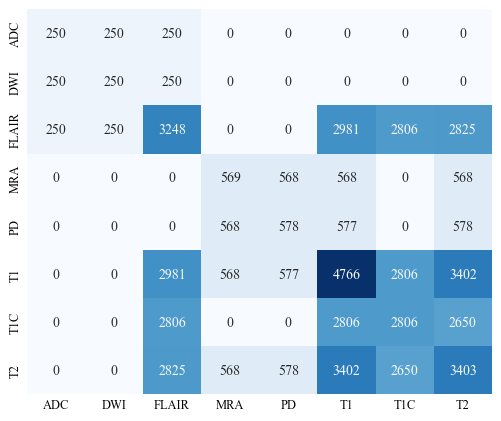

In [6]:
df['modality'] = df['modality'].apply(map_modality)
print(df['modality'].value_counts())

co_occurrence = get_coocurrence(df, "modality")
ax = plot_heatmap(co_occurrence)

# Save figure
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("img/co-occurence_pairwise.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')

In [7]:
grouped = df.groupby("patient")["modality"].apply(set).reset_index()
all_modalities = sorted(set(itertools.chain.from_iterable(grouped['modality'])))

def modality_vector(modality_set):
    return [1 if m in modality_set else 0 for m in all_modalities]

grouped['modality_vector'] = grouped['modality'].apply(modality_vector)
modality_matrix = pd.DataFrame(grouped['modality_vector'].tolist(), columns=all_modalities, index=grouped['patient'])

In [8]:
modality_matrix

,ADC,DWI,FLAIR,MRA,PD,T1,T1C,T2
patient,,,,,,,,
1,0,0,1,0,0,1,0,1
2,0,0,1,0,0,1,0,1
3,0,0,1,0,0,1,0,1
4,0,0,1,0,0,1,0,1
5,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...
sub-strokecase0246,1,1,1,0,0,0,0,0
sub-strokecase0247,1,1,1,0,0,0,0,0
sub-strokecase0248,1,1,1,0,0,0,0,0


In [8]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(modality_matrix)

/Users/khueluu/.local/share/virtualenvs/brainfm-data--92SuIW6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/khueluu/.local/share/virtualenvs/brainfm-data--92SuIW6/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/khueluu/.local/share/virtualenvs/brainfm-data--92SuIW6/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
def assign_protocol(row):
    present_modalities = [modality for modality in row.index if row[modality] == 1]
    present_modalities = sorted(present_modalities)
    return '-'.join(present_modalities)

modality_matrix['protocol_group'] = modality_matrix.apply(assign_protocol, axis=1)

In [10]:
modality_matrix

,ADC,DWI,FLAIR,MRA,PD,T1,T1C,T2,protocol_group
patient,,,,,,,,,
1,0,0,1,0,0,1,0,1,FLAIR-T1-T2
2,0,0,1,0,0,1,0,1,FLAIR-T1-T2
3,0,0,1,0,0,1,0,1,FLAIR-T1-T2
4,0,0,1,0,0,1,0,1,FLAIR-T1-T2
5,0,0,1,0,0,1,0,1,FLAIR-T1-T2
...,...,...,...,...,...,...,...,...,...
sub-strokecase0246,1,1,1,0,0,0,0,0,ADC-DWI-FLAIR
sub-strokecase0247,1,1,1,0,0,0,0,0,ADC-DWI-FLAIR
sub-strokecase0248,1,1,1,0,0,0,0,0,ADC-DWI-FLAIR


In [11]:
modality_matrix['protocol_group'].unique()

array(['FLAIR-T1-T2', 'FLAIR', 'FLAIR-T1-T1C-T2', 'MRA-PD-T1-T2',
       'PD-T1-T2', 'T1', 'MRA-T1', 'MRA-PD-T2', 'FLAIR-T1-T1C',
       'ADC-DWI-FLAIR'], dtype=object)

In [12]:
embedding

array([[-12.792772 ,  16.288332 ],
       [-12.837703 ,  16.133966 ],
       [-12.877689 ,  16.030497 ],
       ...,
       [ 23.586615 ,  -3.478547 ],
       [ 22.87072  ,  -3.2644038],
       [ 23.375925 ,  -3.4299936]], dtype=float32)

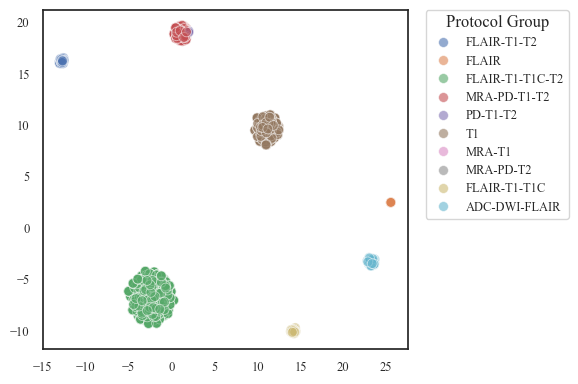

In [18]:


# Use same embedding from UMAP
plt.figure(figsize=(6,4))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
                hue=modality_matrix['protocol_group'],
                s=50, alpha=0.6)

# Move legend outside
plt.legend(title='Protocol Group', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig("img/co-occurrence_clustering.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()

In [14]:
modality_matrix['protocol_group'].value_counts()

protocol_group
FLAIR-T1-T1C-T2    2650
T1                 1207
MRA-PD-T1-T2        567
ADC-DWI-FLAIR       250
FLAIR-T1-T2         175
FLAIR-T1-T1C        156
FLAIR                17
PD-T1-T2             10
MRA-T1                1
MRA-PD-T2             1
Name: count, dtype: int64

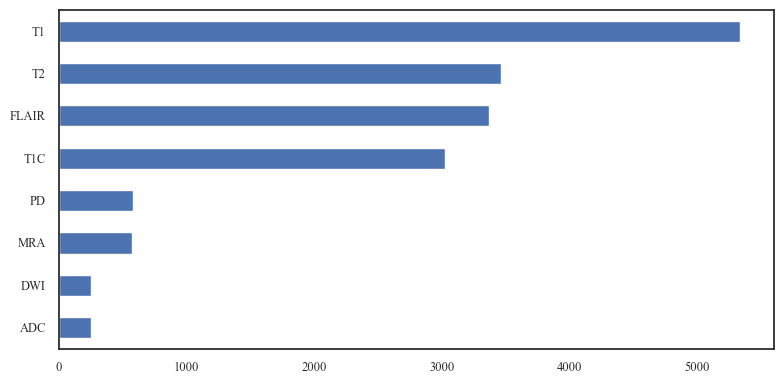

In [21]:
# df['modality'].value_counts().sort_index().plot(kind='barh', figsize=(8, 4))
# plt.ylabel('')

# plt.tight_layout()
# plt.savefig("img/modality_distribution.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
# plt.show()
df['modality'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(8, 4))
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.savefig("img/modality_distribution.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()

## 

In [16]:
n_modalities = df['modality'].value_counts().sum()
df['modality'].value_counts() / n_modalities * 100

modality
T1       31.690810
T2       20.565186
FLAIR    20.018998
T1C      17.947043
PD        3.431489
MRA       3.378057
ADC       1.484208
DWI       1.484208
Name: count, dtype: float64

## Voxel spacing

In [17]:
def parse_voxel_spacing(vs):
    if isinstance(vs, str):
        return tuple(map(float, vs.strip("()").split(",")))
    return vs

def compute_anisotropy_ratio(vs):
    vs = np.array(vs)
    return np.max(vs) / np.min(vs)

def categorize_anisotropy(ratio, iso_threshold=1.0, high_aniso_threshold=2.0):
    if ratio == iso_threshold:
        return 'Isotropic'
    elif ratio < high_aniso_threshold:
        return 'Mildly Anisotropic'
    else:
        return 'Highly Anisotropic'

In [18]:
df['voxel_spacing_parsed'] = df['voxel_spacing'].apply(parse_voxel_spacing)
df['anisotropy_ratio'] = df['voxel_spacing_parsed'].apply(compute_anisotropy_ratio)
df['anisotropy_category'] = df['anisotropy_ratio'].apply(categorize_anisotropy)

summary = df['anisotropy_category'].value_counts()
summary

anisotropy_category
Isotropic             7968
Mildly Anisotropic    7152
Highly Anisotropic    1724
Name: count, dtype: int64

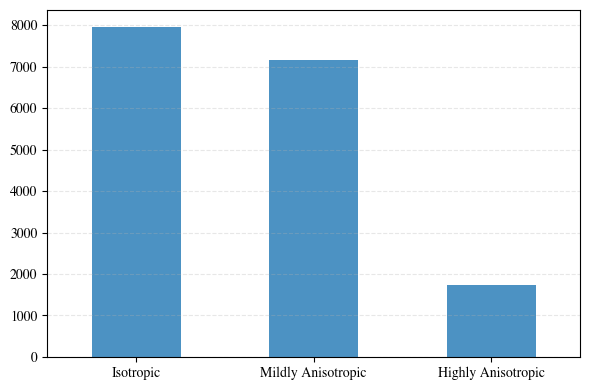

In [19]:
plt.figure(figsize=(6,4))
summary.plot(kind='bar', alpha=0.8)
plt.xlabel('')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("img/anisotropy_distribution.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()

In [20]:
dataset_summary = df.groupby('dataset')['anisotropy_category'].value_counts().unstack().fillna(0)
print("\nPer-dataset anisotropy summary:")
dataset_summary


Per-dataset anisotropy summary:


anisotropy_category,Highly Anisotropic,Isotropic,Mildly Anisotropic
dataset,,,
BraTS25MEN,0.0,4564.0,0.0
BraTS25MET,1424.0,2064.0,2412.0
BraTS25SSA,0.0,380.0,0.0
BrainMetShare,0.0,0.0,624.0
EPISURG,1.0,2.0,695.0
ISLES22,213.0,389.0,148.0
IXI,74.0,0.0,2232.0
MSBaghdad,0.0,180.0,0.0
MSLesSeg,0.0,345.0,0.0


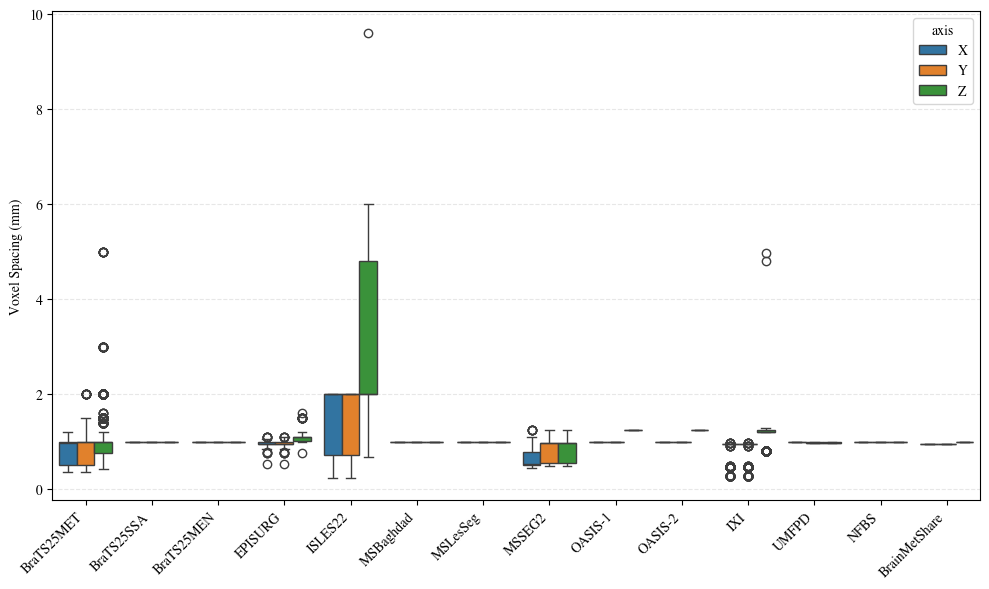

In [68]:
df['voxel_spacing_parsed'] = df['voxel_spacing'].apply(parse_voxel_spacing)
df[['spacing_x', 'spacing_y', 'spacing_z']] = pd.DataFrame(df['voxel_spacing_parsed'].tolist(), index=df.index)

df_long = df.melt(id_vars=['dataset'], value_vars=['spacing_x', 'spacing_y', 'spacing_z'],
                  var_name='axis', value_name='spacing')

df_long['axis'] = df_long['axis'].str.replace('spacing_', '').str.upper()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_long, x='dataset', y='spacing', hue='axis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Voxel Spacing (mm)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("img/voxel_box.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()

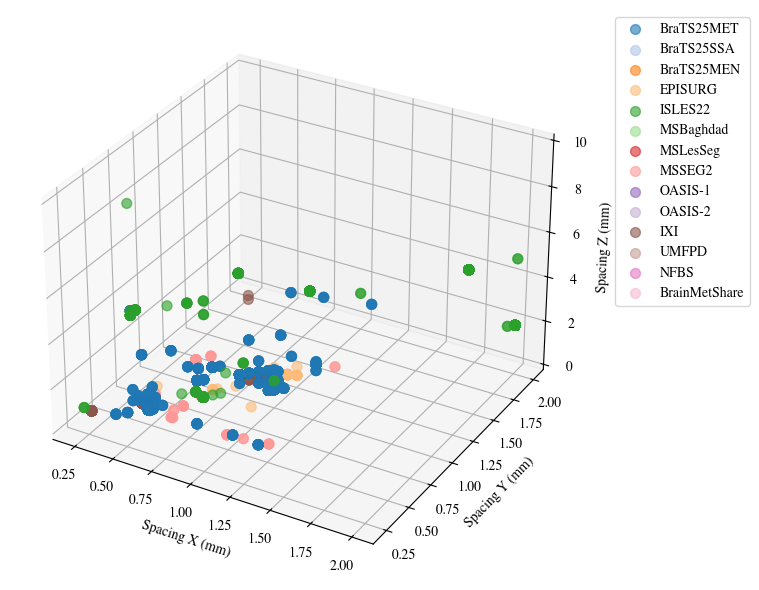

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

datasets = df['dataset'].unique()
colors = plt.cm.tab20.colors

for i, dataset in enumerate(datasets):
    subset = df[df['dataset'] == dataset]
    ax.scatter(subset['spacing_x'], subset['spacing_y'], subset['spacing_z'], 
               color=colors[i % len(colors)], label=dataset, s=50, alpha=0.6)

ax.set_xlabel('Spacing X (mm)')
ax.set_ylabel('Spacing Y (mm)')
ax.set_zlabel('Spacing Z (mm)')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


plt.tight_layout()
plt.savefig("img/voxel_3d.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()

## Orientation

In [40]:
df.shape

(16844, 24)

In [59]:
summary = (
    df.groupby('axcodes')['dataset']
    .agg(['count', lambda x: ', '.join(sorted(x.unique()))])
    .reset_index()
    .sort_values('count', ascending=False)
)
summary.columns = ['axcodes', 'count', 'datasets']

# Export to LaTeX
print(summary.to_latex(index=False, escape=False, 
      caption='Axial orientation distribution and dataset sources', 
      label='tab:axcodes_datasets'))

\begin{table}
\caption{Axial orientation distribution and dataset sources}
\label{tab:axcodes_datasets}
\begin{tabular}{lrl}
\toprule
axcodes & count & datasets \\
\midrule
RAS & 6592 & BraTS25MET, BraTS25SSA, BrainMetShare, EPISURG, ISLES22 \\
LPS & 5012 & BraTS25MEN, BraTS25MET, BraTS25SSA \\
LAS & 3473 & BraTS25MET, EPISURG, ISLES22, IXI, MSBaghdad, MSLesSeg, MSSEG2, OASIS-1, UMFPD \\
RSA & 664 & EPISURG \\
PSR & 582 & EPISURG, IXI \\
ASL & 373 & OASIS-2 \\
PIR & 129 & EPISURG, NFBS \\
LIP & 9 & EPISURG \\
LSP & 5 & EPISURG \\
ASR & 4 & EPISURG \\
LSA & 1 & EPISURG \\
\bottomrule
\end{tabular}
\end{table}



## Intensity

In [60]:
df.columns

Index(['shape', 'voxel_spacing', 'axcodes', 'min_value', 'max_value',
       'median_value', 'affine', 'orientation', 'is_hwd', 'image_id',
       'patient', 'modality', 'timepoint', 'image_path',
       'preprocessed_image_path', 'dataset', 'voxel_spacing_parsed',
       'anisotropy_ratio', 'anisotropy_category', 'spacing_x', 'spacing_y',
       'spacing_z', 'range', 'z_median'],
      dtype='object')

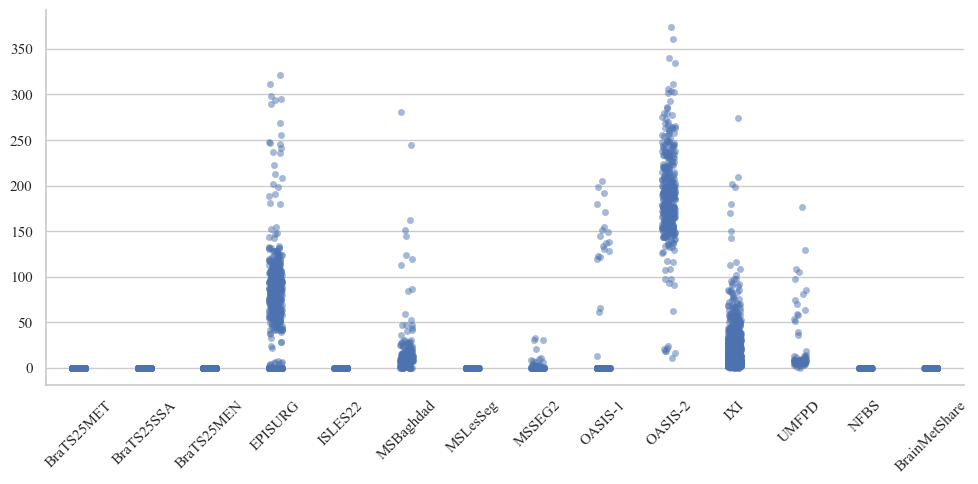

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.figure(figsize=(10, 5))
sns.stripplot(data=df, x='dataset', y='median_value', jitter=True, alpha=0.5)
#plt.title('Median Intensity per Image (by Dataset)')
sns.despine(top=True, right=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("img/median_intensity_per_image.jpeg", format='jpeg', dpi=1200, bbox_inches='tight')
plt.show()


In [93]:
from scipy.stats import kruskal

groups = [group['median_value'].values for _, group in df.groupby('dataset')]
stat, p = kruskal(*groups)

print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p = {p:.3e}")

if p < 0.05:
    print("Result: Statistically significant difference in median intensity between datasets (p < 0.05).")
else:
    print("Result: No statistically significant difference in median intensity between datasets (p ≥ 0.05).")

Kruskal-Wallis H-statistic = 15093.849, p = 0.000e+00
Result: Statistically significant difference in median intensity between datasets (p < 0.05).
